In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.applications import ResNet50 
from keras.applications.vgg16 import preprocess_input
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
SIZE = 256 #Constant size throughout the model

In [3]:
train_images = []
train_labels = []

In [4]:
for directory_path in glob.glob("/kaggle/input/aadharcards/aadharcards_desti/train/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
#Capture test/validation data and labels into respective lists
test_images = []
test_labels = []
for directory_path in glob.glob("/kaggle/input/aadharcards/aadharcards_desti/test/*"):
    label1 = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label1)

In [7]:
#Encode labels from text to integers.
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [8]:
x_test = np.array(x_test)
x_train, x_test = x_train / 255.0, x_test / 255.0

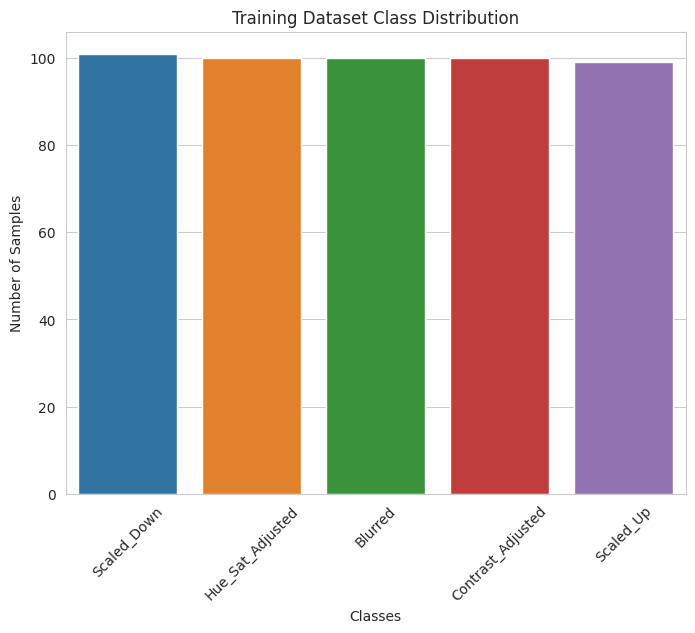

In [9]:
train_class_distribution = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=train_class_distribution.index, y=train_class_distribution.values)
plt.title('Training Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

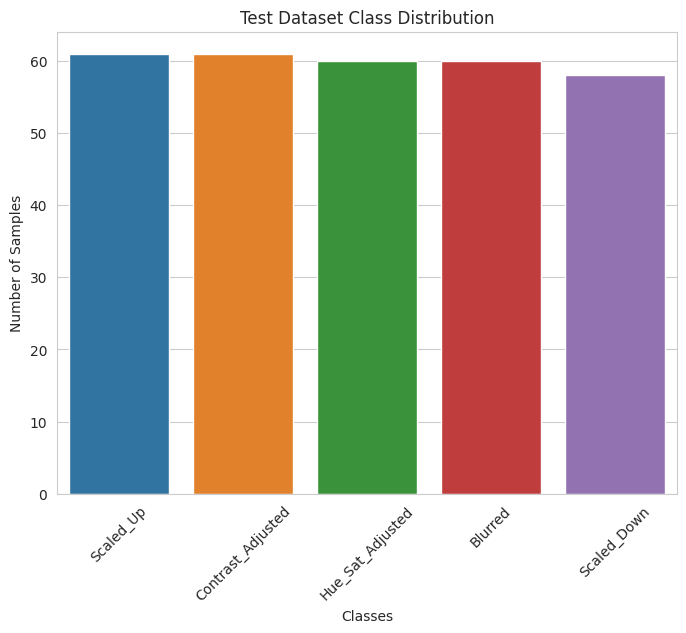

In [10]:
test_class_distribution = pd.Series(test_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=test_class_distribution.index, y=test_class_distribution.values)
plt.title('Test Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

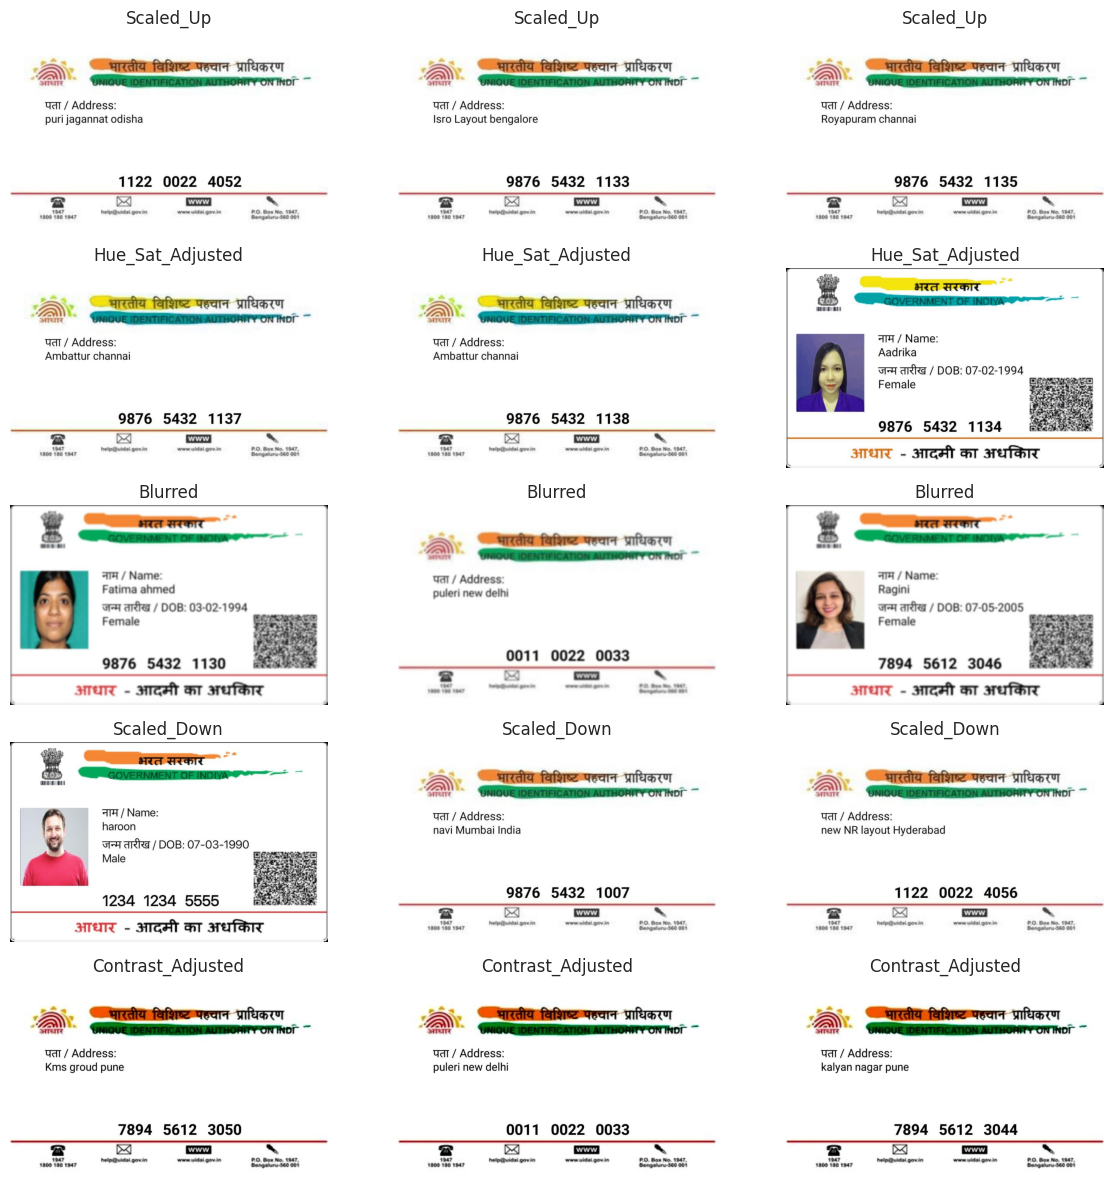

In [11]:
import random

def display_sample_images(data_path, class_names, num_samples=3):
    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        sample_images = random.sample(glob.glob(os.path.join(class_path, "*.jpg")), num_samples)
        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_name}')
    plt.tight_layout()
    plt.show()

train_path = "/kaggle/input/aadharcards/aadharcards_desti/train"
class_names = os.listdir(train_path)
display_sample_images(train_path, class_names)

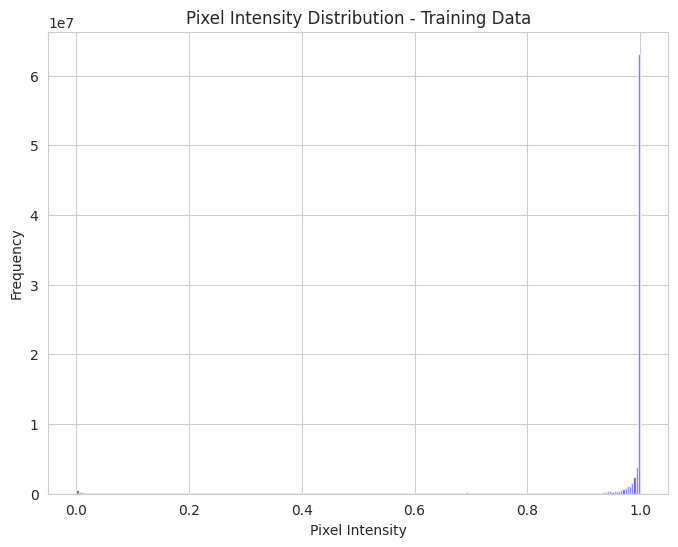

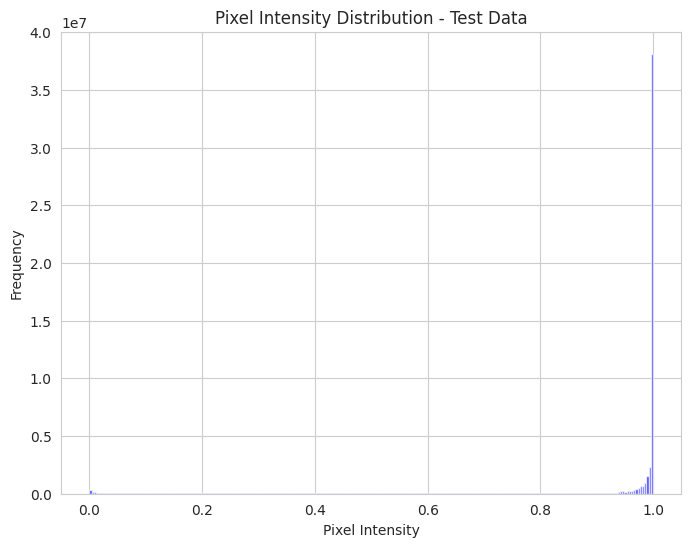

In [12]:
def plot_pixel_intensity_histogram(images, title):
    plt.figure(figsize=(8, 6))
    pixel_values = images.ravel()
    plt.hist(pixel_values, bins=256, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_histogram(x_train, 'Pixel Intensity Distribution - Training Data')

plot_pixel_intensity_histogram(x_test, 'Pixel Intensity Distribution - Test Data')

In [13]:
# Load ResNet50 model without the classifier (fully connected layers)
ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Make the layers non-trainable so as to use pre-trained weights
for layer in ResNet_model.layers:
    layer.trainable = False

ResNet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Feature extraction using ResNet50
# Extract features from the training images
train_features = ResNet_model.predict(x_train)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten the features

# Extract features from the test images
test_features = ResNet_model.predict(x_test)
test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten the features

16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step


In [15]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_features, y_train)

# Predictions using XGBoost
predictions = xgb_model.predict(test_features)

In [16]:
# Classification Report
print("Classification Report:\n", classification_report(test_labels_encoded, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99        61
           2       1.00      0.98      0.99        60
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        61

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [17]:
accuracy = accuracy_score(test_labels_encoded, predictions)
print("Accuracy: ", accuracy)

loss = log_loss(test_labels_encoded, xgb_model.predict_proba(test_features))
print("Loss: ", loss)

Accuracy:  0.9966666666666667
Loss:  0.019387484657904863


<Axes: >

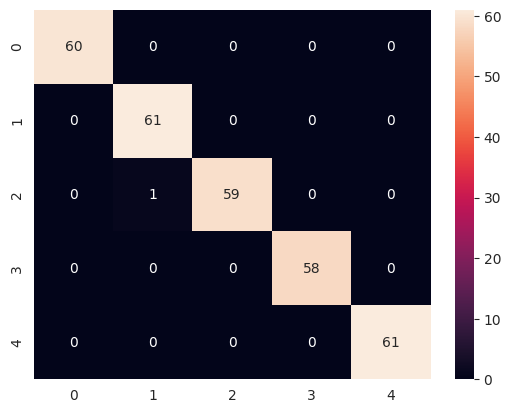

In [18]:
# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predictions)
sns.heatmap(cm, annot=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
The prediction for this image is:  ['Blurred']
The actual label for this image is:  Blurred


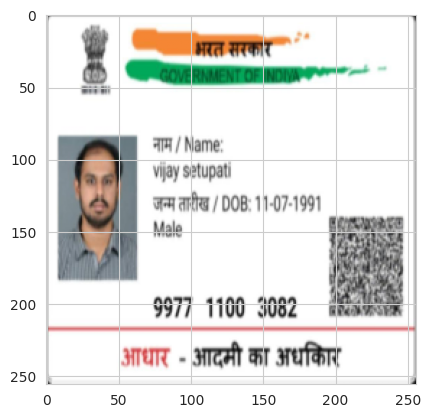

In [19]:
# Predictions on Random Test Image
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
input_img_features = ResNet_model.predict(input_img).reshape(1, -1)
prediction = xgb_model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
The prediction for this image is:  ['Scaled_Up']
The actual label for this image is:  Scaled_Up


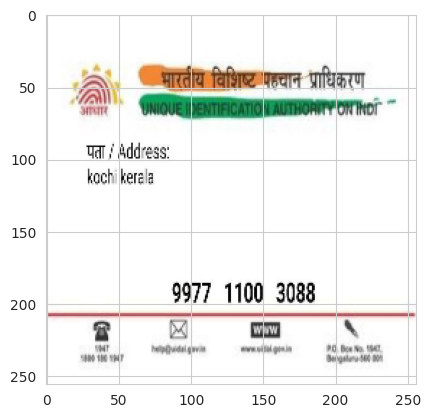

In [20]:
# Predictions on Random Test Image
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
input_img_features = ResNet_model.predict(input_img).reshape(1, -1)
prediction = xgb_model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction]) 
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

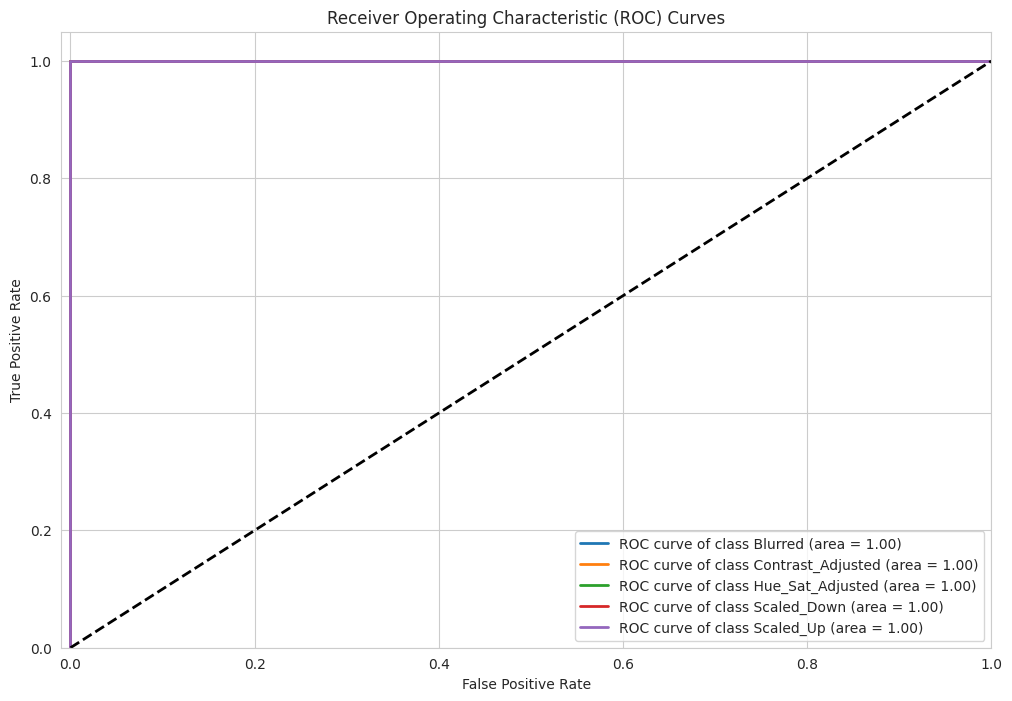

<Figure size 1000x800 with 0 Axes>

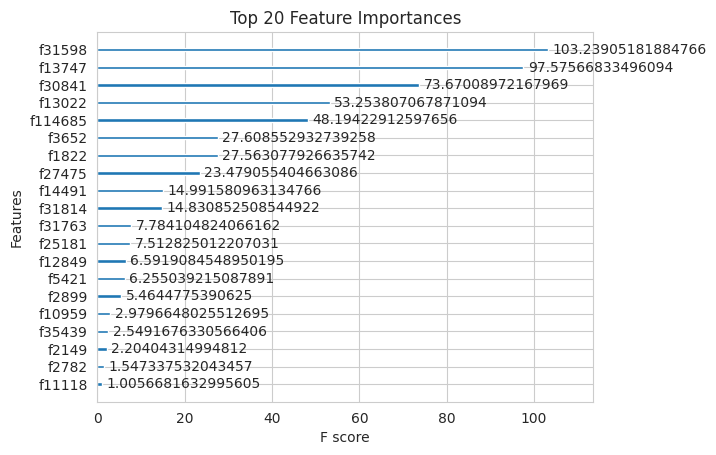

In [25]:
xgb_model.fit(train_features, train_labels_encoded)  # Train the model

# ROC Curves for Each Class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
n_classes = len(le.classes_)
y_test_binarized = label_binarize(test_labels_encoded, classes=range(n_classes))
y_score = xgb_model.predict_proba(test_features)  # Get predictions for the test features

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.inverse_transform([i])[0], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title('Top 20 Feature Importances')
plt.show()